In [ ]:
# default_exp ratio

> The email portion of this campaign was actually run as an A/B test. Half the emails sent out were generic upsells to your product while the other half contained personalized messaging around the users’ usage of the site.

这是 AB Test 的实验内容。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# export
'''Calculate conversion rates and related metrics.'''

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def conversion_rate(dataframe, column_names, converted = 'converted', id_name = 'user_id'):
    '''Calculate conversion rate.
    Cite https://www.datacamp.com/courses/analyzing-marketing-campaigns-with-pandas

    Parmaters
    ---------
    dataframe: pandas.DataFrame
    column_names: str
        The conlumn(s) chosen to partition groups to 
        calculate conversion rate.
    converted: str
        The column with True and False to determine 
        whether users are converted.        
    id_name: str
        The column saved user_id.
    
    
    Returns
    -------
    conversion_rate: conversion rate'''
    # Total number of converted users
    column_conv = dataframe[dataframe[converted] == True] \
        .groupby(column_names)[id_name] \
        .nunique()

    # Total number users
    column_total = dataframe \
        .groupby(column_names)[id_name] \
        .nunique() 
    
    # Conversion rate 
    conversion_rate = column_conv/column_total
    
    # Fill missing values with 0
    conversion_rate = conversion_rate.fillna(0)
    
    return conversion_rate

In [5]:
marketing = pd.read_csv("data/marketing.csv",
                        parse_dates = ['date_served', 'date_subscribed', 'date_canceled'])

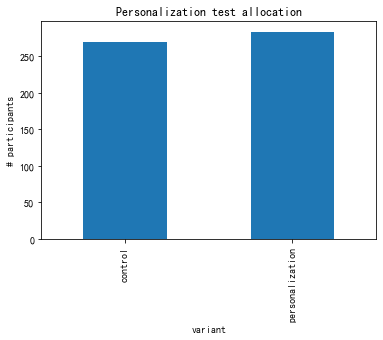

In [6]:
# Subset the DataFrame
email = marketing[marketing.marketing_channel == 'Email']

# Group the email DataFrame by variant 
alloc = email.groupby(['variant']).user_id.nunique()

# Plot a bar chart of the test allocation
alloc.plot(kind = 'bar')
plt.title('Personalization test allocation')
plt.ylabel('# participants')
plt.show()

差异不大。

In [7]:
# Group marketing by user_id and variant
subscribers = email.groupby(['user_id', 
                             'variant'])['converted'].max()
subscribers_df = pd.DataFrame(subscribers.unstack(level=1)) 

# Drop missing values from the control column
control = subscribers_df['control'].dropna()

# Drop missing values from the personalization column
personalization = subscribers_df['personalization'].dropna()

print('Control conversion rate:', np.mean(control))
print('Personalization conversion rate:', np.mean(personalization))

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


这种 Python 写法我觉得有点复杂。

$$\begin{array}{l}{\text { Calculating lift: }} \\ {\qquad \frac{\text { Treatment conversion rate - Control conversion rate }}{\text { Control conversion rate }}}\end{array}$$

注意这里的 lift 是转化率的比较，因此是可以超过 100 %

In [10]:
# export
def lift(a,b, sig = 2):
    '''Calculate lift statistic for an AB test.
    Cite https://www.datacamp.com/courses/analyzing-marketing-campaigns-with-pandas

    Parmaters
    ---------
    a: float.
        control group.
    b: float.
        test group.
    sig: integer.
        default 2.

    Returns
    -------
    lift: lift statistic'''
    # Calcuate the mean of a and b
    a_mean = np.mean(a)
    b_mean = np.mean(b)

    # Calculate the lift using a_mean and b_mean
    lift = b_mean/a_mean - 1

    return str(round(lift*100, sig)) + '%'

In [13]:
lift(control, personalization, sig = 3)

'38.853%'

## 查看是否统计显著

In [40]:
# export
from scipy import stats

def lift_sig(a,b):
    '''Calculate lift statistical significance for an AB test.
    Cite https://www.datacamp.com/courses/analyzing-marketing-campaigns-with-pandas

    Parmaters
    ---------
    a: float.
        control group.
    b: float.
        test group.
    sig: integer.
        default 2.

    Returns
    -------
    lift: lift statistic'''

    output = stats.ttest_ind(a,b)
    t_value, p_value = output.statistic,output.pvalue
    print('The t value of  the two variables is %.3f  with p value %.3f' % (t_value, p_value))

    return (t_value, p_value)

In [41]:
t_value, p_value = lift_sig(control,personalization )

The t value of  the two variables is -0.577  with p value 0.580


> In the next lesson, you will explore whether that holds up across all demographics.

这真是做 AB test 一个成熟的思维，不代表每一个 group 都很好。


In [53]:
# export
def ab_test(df, segment, id_name = 'user_id', test_column = 'variant', converted = 'converted'):
    '''Calculate lift statistic by segmentation.
    Cite https://www.datacamp.com/courses/analyzing-marketing-campaigns-with-pandas

    Parmaters
    ---------
    df: pandas.DataFrame.

    segment: str.
        group column.
    
    id_name: user_id
    
    test_column: str
        The column indentify test or ctrl groups.
        
    converted: logical.
        Whether converted or not.

    Returns
    -------
    lift: lift statistic'''
    # Build a for loop for each segment in marketing
    for subsegment in np.unique(marketing[segment].values):
        print('Group - %s: ' % subsegment)

        df1 = df[df[segment] == subsegment]

        df2 = df1.groupby([id_name, test_column])[converted].max()
        df2 = pd.DataFrame(df2.unstack(level=1)) 
        ctrl = df2.iloc[:,0].dropna()
        test = df2.iloc[:,1].dropna()
        
        # information
        print('lift:', lift(ctrl, test))
        lift_sig(ctrl, test)

In [54]:
df = marketing[marketing['marketing_channel'] == 'Email']
ab_test(df, segment='language_displayed', id_name='user_id', test_column='variant', converted='converted')

Group - Arabic: 
lift: 50.0%
The t value of  the two variables is -0.577  with p value 0.580
Group - English: 
lift: 39.0%
The t value of  the two variables is -2.218  with p value 0.027
Group - German: 
lift: -1.62%
The t value of  the two variables is 0.191  with p value 0.849
Group - Spanish: 
lift: 166.67%
The t value of  the two variables is -2.357  with p value 0.040


In [52]:
df.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
354,a100000526,2018-01-01,Email,personalization,True,Arabic,Arabic,0-18 years,2018-01-01,NaT,Email,True
358,a100000530,2018-01-05,Email,personalization,True,Arabic,Arabic,19-24 years,2018-01-05,NaT,Email,True
362,a100000534,2018-01-09,Email,personalization,False,English,English,45-55 years,2018-01-09,NaT,Email,True
366,a100000538,2018-01-13,Email,personalization,True,Arabic,Arabic,24-30 years,2018-01-13,2018-01-23,Email,False
370,a100000542,2018-01-17,Email,personalization,True,English,English,0-18 years,2018-01-17,2018-02-12,Email,False


> Often treatment will not affect all people uniformly. Some people will love a particular marketing campaign while others hate it. As a marketing data scientist, it's your responsibility to enable your marketing stakeholders to target users according to their preferences.